In [1]:
import torch
from torch import nn
import numpy as np

In [2]:
import os
def check_data(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"# of directories: {len(dirnames)} and {len(filenames)} images in '{dirpath}'.")

In [3]:
from pathlib import Path
data_path = Path("data/")
image_path = data_path / "desert101"

In [4]:
check_data(image_path)

# of directories: 2 and 1 images in 'data/desert101'.
# of directories: 4 and 1 images in 'data/desert101/test'.
# of directories: 0 and 20 images in 'data/desert101/test/cup_cakes'.
# of directories: 0 and 20 images in 'data/desert101/test/donuts'.
# of directories: 0 and 20 images in 'data/desert101/test/cannoli'.
# of directories: 0 and 20 images in 'data/desert101/test/baklava'.
# of directories: 4 and 1 images in 'data/desert101/train'.
# of directories: 0 and 80 images in 'data/desert101/train/cup_cakes'.
# of directories: 0 and 80 images in 'data/desert101/train/donuts'.
# of directories: 0 and 80 images in 'data/desert101/train/cannoli'.
# of directories: 0 and 80 images in 'data/desert101/train/baklava'.


In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
# let's actually see some images
import random
from PIL import Image

random.seed(42) 

# 1. Get all image paths 
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

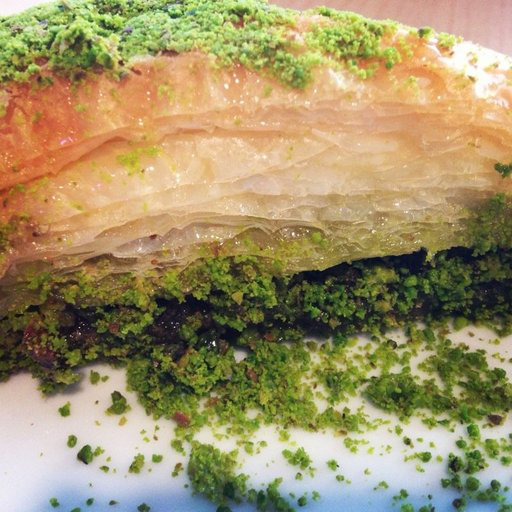

In [7]:
img

In [8]:
# let's dive into how we can actually create a custom dataset

In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [10]:
# we will get creative with transforms this time

In [11]:
data_transform = transforms.Compose([
    # Resize the images to 64x64 (this will surely make them worse, this is our choice, we can leave it as it is, but most probably we will risk achieving the same result with more computational power)
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.4), # p = probability of flip, 0.4 = 40% chance
    # Data Augmentation!!
    transforms.TrivialAugmentWide(),
    # Turn the image into a torch.Tensor
    transforms.ToTensor() 
])

In [12]:
# we will use ImageFolder from torchvision to apply transforms and create data files to load them into DataLoaders later on

from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform,  
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

In [13]:
train_data

Dataset ImageFolder
    Number of datapoints: 316
    Root location: data/desert101/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.4)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )

In [14]:
test_data

Dataset ImageFolder
    Number of datapoints: 77
    Root location: data/desert101/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.4)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )

In [15]:
# we will also need labels (class names)

In [16]:
class_names = train_data.classes

In [17]:
class_names

['baklava', 'cannoli', 'cup_cakes', 'donuts']

In [18]:
len(train_data), len(test_data)

(316, 77)

In [19]:
# now we can pass this data image to dataloader so we can finally get our data ready for nn

In [20]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) 

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False)

In [21]:
# we finally have the data ready, let's move onto creating nn and see if it works out

In [22]:
train_dataloader

In [23]:
class DesertClassifier(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) 

In [24]:
torch.manual_seed(42)
model_0 = DesertClassifier(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=32, 
                  output_shape=len(train_data.classes))

In [25]:
#!pip install torchinfo
# this is also how you can calculate what to write in output shape in classifier layer
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
DesertClassifier                         [1, 4]                    --
├─Sequential: 1-1                        [1, 32, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 32, 64, 64]           896
│    └─ReLU: 2-2                         [1, 32, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 32, 64, 64]           9,248
│    └─ReLU: 2-4                         [1, 32, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 32, 32, 32]           --
├─Sequential: 1-2                        [1, 32, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 32, 32, 32]           9,248
│    └─ReLU: 2-7                         [1, 32, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 32, 32, 32]           9,248
│    └─ReLU: 2-9                         [1, 32, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 32, 16, 16]           --
├─Seq

In [26]:
# let's turn our training and testing into functions

In [27]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [28]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [29]:
# finally create a train function that combines both of them
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [30]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Recreate an instance of model
model_0 = DesertClassifier(input_shape=3,
                  hidden_units=32, 
                  output_shape=len(train_data.classes))

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

Epoch: 1 | train_loss: 1.3941 | train_acc: 0.2205 | test_loss: 1.3821 | test_acc: 0.2083
Epoch: 2 | train_loss: 1.3846 | train_acc: 0.2473 | test_loss: 1.3750 | test_acc: 0.2292
Epoch: 3 | train_loss: 1.3642 | train_acc: 0.3420 | test_loss: 1.3735 | test_acc: 0.3117
Epoch: 4 | train_loss: 1.3516 | train_acc: 0.3384 | test_loss: 1.3475 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.3262 | train_acc: 0.3286 | test_loss: 1.3245 | test_acc: 0.3838
Epoch: 6 | train_loss: 1.3152 | train_acc: 0.3554 | test_loss: 1.3086 | test_acc: 0.3478
Epoch: 7 | train_loss: 1.2772 | train_acc: 0.4268 | test_loss: 1.3021 | test_acc: 0.3534
Epoch: 8 | train_loss: 1.2490 | train_acc: 0.4353 | test_loss: 1.3129 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.2952 | train_acc: 0.4094 | test_loss: 1.2332 | test_acc: 0.4359
Epoch: 10 | train_loss: 1.1841 | train_acc: 0.4522 | test_loss: 1.3078 | test_acc: 0.3846


In [31]:
model_0_results

{'train_loss': [1.3940945267677307,
  1.3845934748649598,
  1.3642012238502503,
  1.3516165375709535,
  1.3262367367744445,
  1.3151775002479553,
  1.2771690726280212,
  1.249021553993225,
  1.2952149271965028,
  1.1841467142105102],
 'train_acc': [0.22053571428571428,
  0.24732142857142855,
  0.3419642857142857,
  0.33839285714285716,
  0.32857142857142857,
  0.3553571428571428,
  0.4267857142857143,
  0.4352678571428571,
  0.409375,
  0.45223214285714286],
 'test_loss': [1.382114291191101,
  1.3749618530273438,
  1.3735121091206868,
  1.3475074768066406,
  1.3245285749435425,
  1.3085830609003704,
  1.302067756652832,
  1.312908411026001,
  1.2331799666086833,
  1.3077720403671265],
 'test_acc': [0.20833333333333334,
  0.22916666666666666,
  0.31169871794871795,
  0.2604166666666667,
  0.3838141025641026,
  0.3477564102564103,
  0.3533653846153846,
  0.2604166666666667,
  0.4358974358974359,
  0.3846153846153846]}

In [32]:
import matplotlib.pyplot as plt
def plot_loss_curves(results):
    loss = results['train_loss']
    test_loss = results['test_loss']
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

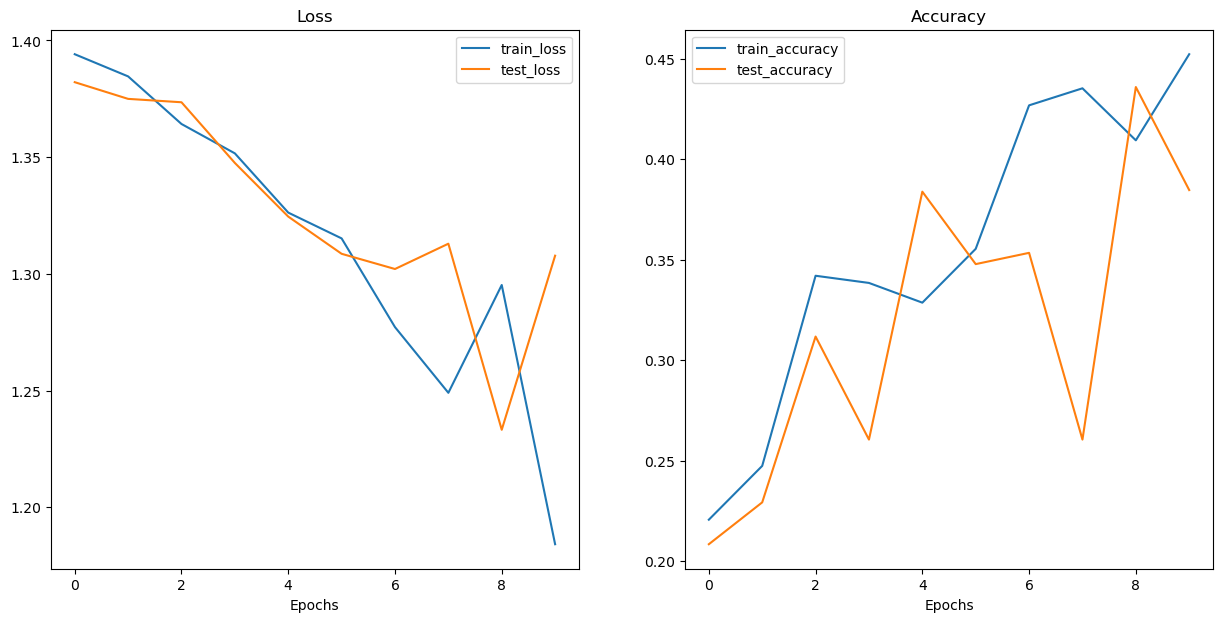

In [33]:
plot_loss_curves(model_0_results)

In [34]:
def make_predictions(model: torch.nn.Module, data: list):
    """
    data: [img_tensor, img_tensor, ...]  # her biri [C, H, W]
    return: [N, num_classes] olasılık tensörü
    """
    pred_probs = []
    model.eval()

    with torch.inference_mode():
        for sample in data:
            # [C, H, W] -> [1, C, H, W]
            sample = sample.unsqueeze(0)

            # Logits al
            pred_logit = model(sample)    # shape: [1, num_classes]

            # Softmax ile olasılığa çevir
            prob = torch.softmax(pred_logit, dim=1)  # [1, num_classes]

            # Batch boyutunu sıkıştır
            pred_probs.append(prob.squeeze(0))       # [num_classes]

    # Hepsini birleştir → [N, num_classes]
    return torch.stack(pred_probs)

In [35]:
def show_random_predictions(model, dataset, class_names, n=9):
    model.eval()
    
    plt.figure(figsize=(4, 4))

    # random 9 index seç
    indices = random.sample(range(len(dataset)), n)

    with torch.inference_mode():
        for i, idx in enumerate(indices):
            img, true_label = dataset[idx]

            # modele uygun hale getir
            img_input = img.unsqueeze(0)  
            logits = model(img_input)
            pred_label = logits.argmax(dim=1).item()

            # görseli çizmek için permute
            img_show = img.permute(1, 2, 0)

            # doğru mu yanlış mı?
            correct = (pred_label == true_label)
            color = "green" if correct else "red"

            # subplot
            plt.subplot(3, 3, i + 1)
            plt.imshow(img_show)
            plt.axis("off")

            plt.title(
                f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}",
                color=color,
                fontsize=10
            )

    plt.tight_layout()
    plt.show()

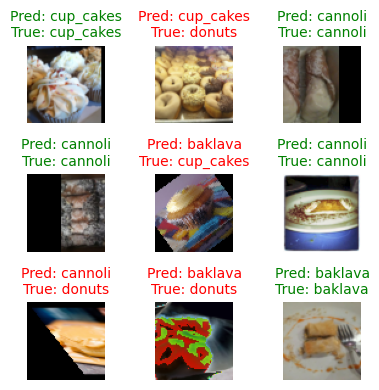

In [51]:
show_random_predictions(model_0, test_data, class_names)

In [52]:
# let's find a baklava image online and try with that

In [53]:
online_image_path = data_path / "baklava-online.jpg"

In [54]:
online_image_path

PosixPath('data/baklava-online.jpg')

In [56]:
import torchvision
single_image = torchvision.io.read_image(str(online_image_path))

In [57]:
single_image

tensor([[[30, 30, 31,  ..., 16, 15, 15],
         [32, 32, 33,  ..., 16, 15, 15],
         [30, 31, 31,  ..., 16, 16, 15],
         ...,
         [79, 81, 81,  ..., 48, 48, 48],
         [81, 82, 82,  ..., 48, 48, 48],
         [79, 81, 81,  ..., 48, 47, 47]],

        [[45, 45, 46,  ..., 29, 28, 28],
         [47, 47, 48,  ..., 29, 28, 28],
         [45, 46, 46,  ..., 29, 29, 28],
         ...,
         [75, 77, 77,  ..., 45, 45, 45],
         [77, 78, 78,  ..., 45, 45, 45],
         [75, 77, 77,  ..., 45, 44, 44]],

        [[52, 52, 53,  ..., 38, 37, 37],
         [54, 54, 55,  ..., 38, 37, 37],
         [52, 53, 53,  ..., 38, 38, 37],
         ...,
         [72, 74, 74,  ..., 40, 40, 40],
         [74, 75, 75,  ..., 40, 40, 40],
         [72, 74, 74,  ..., 40, 39, 39]]], dtype=torch.uint8)

single image is in tensor format, however, this is uint8 dtype

It means that its values are between [0, 255]. But our model takes image tensors of datatype torch.float32 and with values between [0, 1].

So we need to tranform it a little bit

In [73]:
# we should spesify the float32 dtype here like this
single_image = torchvision.io.read_image(str(online_image_path)).type(torch.float32)

In [74]:
# then convert numbers into [0,1] by dividing it to 255
single_image = single_image / 255

(np.float64(-0.5), np.float64(1199.5), np.float64(1199.5), np.float64(-0.5))

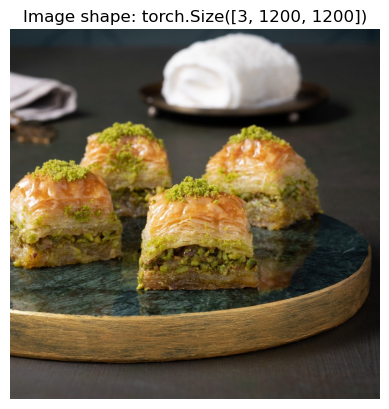

In [75]:
plt.imshow(single_image.permute(1, 2, 0)) 
plt.title(f"Image shape: {single_image.shape}")
plt.axis(False)

In [76]:
# we should do the resize transform as well
single_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
])

# Transform target image
single_image = single_image_transform(single_image)

In [78]:
single_image.shape

torch.Size([3, 64, 64])

In [79]:
single_image.unsqueeze(dim=0).shape

torch.Size([1, 3, 64, 64])

In [80]:
single_image = single_image.unsqueeze(dim=0)

In [82]:
model_0.eval()
with torch.inference_mode():
    logits = model_0(single_image)
    probs = torch.softmax(logits, dim=1)
    pred_idx = probs.argmax(dim=1).item()

print("Predicted class:", class_names[pred_idx])

Predicted class: baklava


In [83]:
# what you can do, you can increase data size, try different augmentation, neuron size and even a different model 
# to try and come up with a better accuracy in this model